## Breast Cancer Dataset - Model Comparison with GridSearchCV

In this notebook, we compare the performance of five machine learning algorithms
(Logistic Regression, Random Forest, KNN, SVC, Decision Tree)
on the Breast Cancer dataset. We use GridSearchCV for hyperparameter tuning
and evaluate each model based on CV Accuracy and Test Accuracy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Breast Cancer Dataset
*   X represents the feature set, and y represents the target labels
*   where 0 indicates malignant cases and 1 indicates benign cases.



In [3]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [4]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# Feature Scaling Explanation

Feature scaling is applied to normalize the distribution and range of all input features.
This step is especially important for distance-based models such as KNN and SVC, where
unscaled features can disproportionately influence distance calculations and decision
boundaries. By standardizing the data, all features contribute equally to the learning
process. For consistency and fairness in model comparison, the same scaled training and
test sets are used across all algorithms.


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

Logistic Regression models the probability of class membership using a logistic function. The model is tuned with GridSearchCV to find the best regularization parameter (`C`), and its final performance is evaluated on the test set using accuracy and the confusion matrix.



In [21]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy"
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)

y_pred_lr = best_model.predict(X_test_scaled)

print("Final Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best CV Accuracy: 0.9802
Final Test Accuracy: 0.9736842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [8]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            text_color = "white" if value > cm.max() / 2 else "black"
            plt.text(j, i, value,
                     ha="center", va="center",
                     color=text_color, fontsize=12, fontweight="bold")

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()


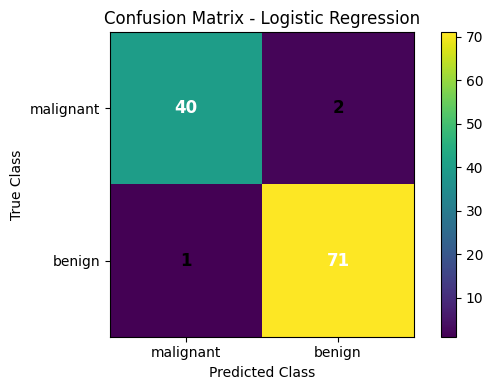

In [22]:
cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, data.target_names,
                      "Confusion Matrix - Logistic Regression")

## Random Forest Classifier

Random Forest combines multiple decision trees to improve classification accuracy and reduce overfitting. We tune parameters such as `n_estimators` and `max_depth` using GridSearchCV, and validate the optimized model on the test set through accuracy metrics and a confusion matrix.



In [10]:
param_grid_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)

print("Best Random Forest parameters:", grid_rf.best_params_)
print(f"RF CV Best Accuracy: {grid_rf.best_score_:.4f}")

best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test_scaled)

print("RF Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

Best Random Forest parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RF CV Best Accuracy: 0.9604
RF Test Accuracy: 0.956140350877193
RF Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



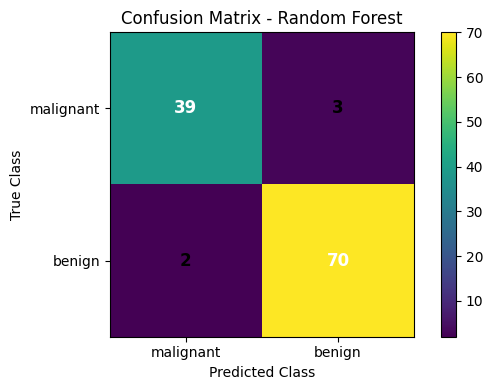

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm, data.target_names,
                      "Confusion Matrix - Random Forest")

## K-Nearest Neighbors (KNN)

KNN classifies instances based on the labels of their closest neighbors in feature space. Hyperparameters like `n_neighbors` and distance metrics are optimized with GridSearchCV, and the model’s final performance is assessed on the test set using accuracy and the confusion matrix.


In [13]:
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)

print("Best KNN parameters:", grid_knn.best_params_)
print(f"Best KNN CV Accuracy: {grid_knn.best_score_:.4f}")

best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test_scaled)

print("KNN Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

Best KNN parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best KNN CV Accuracy: 0.9692
KNN Test Accuracy: 0.9824561403508771
KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



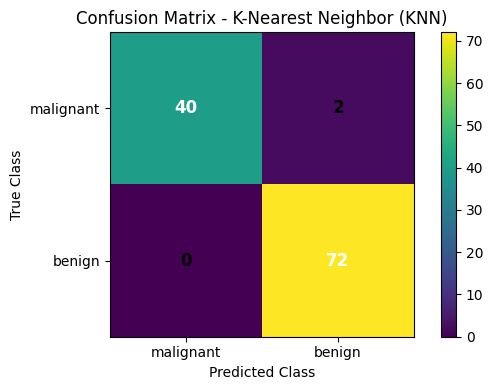

In [14]:
cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm, data.target_names,
                      "Confusion Matrix - K-Nearest Neighbor (KNN)")

## Support Vector Classifier (SVC)

We use an SVC model with an RBF kernel to find the optimal decision boundary between classes. Hyperparameters such as `C` and `gamma` are tuned using GridSearchCV, and the model’s performance is evaluated on the test set using accuracy and a confusion matrix.


In [16]:
param_grid_svc = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.001],
    "kernel": ["rbf"]
}

svc = SVC(random_state=42)

grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_svc.fit(X_train_scaled, y_train)

print("Best SVC parameters:", grid_svc.best_params_)
print(f"SVC CV Best Accuracy: {grid_svc.best_score_:.4f}")

best_svc = grid_svc.best_estimator_

y_pred_svc = best_svc.predict(X_test_scaled)

print("SVC Test Accuracy:", accuracy_score(y_test, y_pred_svc))
print("SVC Classification Report:\n", classification_report(y_test, y_pred_svc))

Best SVC parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC CV Best Accuracy: 0.9802
SVC Test Accuracy: 0.9824561403508771
SVC Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



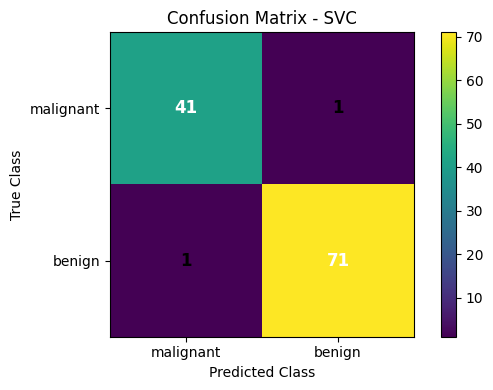

In [17]:
cm = confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(cm, data.target_names,
                      "Confusion Matrix - SVC")

## Decision Tree Classifier

The Decision Tree model classifies data by splitting it into branches based on feature values. To avoid overfitting, parameters like `max_depth` and `min_samples_split` are optimized with GridSearchCV, and its performance is validated on the test set using accuracy and a confusion matrix.


In [18]:
param_grid_dt = {
    "max_depth": [None, 3, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
    "max_features": [None, "sqrt", "log2"]
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_dt.fit(X_train_scaled, y_train)

print("Best Decision Tree parameters:", grid_dt.best_params_)
print(f"Best DT CV Accuracy: {grid_dt.best_score_:.4f}")

best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test_scaled)

print("DT Test Accuracy:", accuracy_score(y_test, y_pred_dt))
print("DT Classification Report:\n", classification_report(y_test, y_pred_dt))

Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}
Best DT CV Accuracy: 0.9429
DT Test Accuracy: 0.956140350877193
DT Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



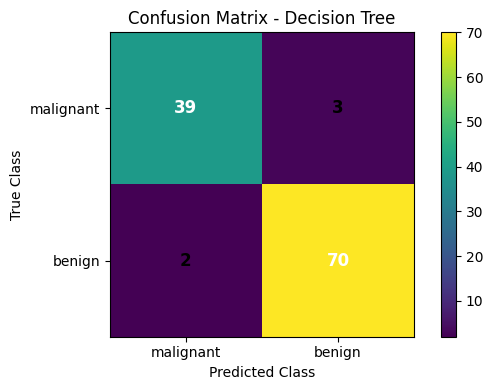

In [19]:
cm = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm, data.target_names,
                      "Confusion Matrix - Decision Tree")

In [20]:
# ================== OVERALL MODEL PERFORMANCE SUMMARY ==================

results = {}
cv_scores = {}

results["Logistic Regression"] = accuracy_score(y_test, y_pred)
cv_scores["Logistic Regression"] = grid.best_score_

results["Random Forest"] = accuracy_score(y_test, y_pred_rf)
cv_scores["Random Forest"] = grid_rf.best_score_

results["KNN"] = accuracy_score(y_test, y_pred_knn)
cv_scores["KNN"] = grid_knn.best_score_

results["SVC (RBF)"] = accuracy_score(y_test, y_pred_svc)
cv_scores["SVC (RBF)"] = grid_svc.best_score_

results["Decision Tree"] = accuracy_score(y_test, y_pred_dt)
cv_scores["Decision Tree"] = grid_dt.best_score_

df_results = pd.DataFrame({
    "CV Accuracy": cv_scores,
    "Test Accuracy": results,
}, columns=["CV Accuracy", "Test Accuracy"])

print("\n MODEL PERFORMANCE TABLE\n")
print(df_results)

best_model_name = df_results["Test Accuracy"].idxmax()
best_model_score = df_results.loc[best_model_name, "Test Accuracy"]

print(f"\n🏆 BEST MODEL: >>> {best_model_name} <<< (Accuracy: {best_model_score:.4f})\n")


 MODEL PERFORMANCE TABLE

                     CV Accuracy  Test Accuracy
Logistic Regression     0.980220       0.973684
Random Forest           0.960440       0.956140
KNN                     0.969231       0.982456
SVC (RBF)               0.980220       0.982456
Decision Tree           0.942857       0.956140

🏆 BEST MODEL: >>> KNN <<< (Accuracy: 0.9825)

